In [1]:
import rpy2
from rpy2.robjects import numpy2ri
numpy2ri.activate()

from skimage import filters, img_as_float
from skimage.exposure import rescale_intensity
from skimage.morphology import disk

from scipy.ndimage.filters import gaussian_laplace

from scipy import fftpack

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.animation as manimation

import numpy as np
import pandas as pd

import pims
import trackpy as tp

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

from skimage.feature import blob_dog, blob_log, blob_doh

from math import sqrt

from skimage.feature import peak_local_max
from scipy.stats import gumbel_r, genextreme

import xml.etree.ElementTree as ET

from skimage.draw import circle

from itertools import product
from os.path import basename

%reload_ext rpy2.ipython

In [2]:
# The blob_log function calls the helper function _prune_blobs to remove overlapping detected blobs
# This function is not accessible from the module, so I've just pasted the source code here
# We want to have access to _prune_blobs so that we can remove overlapping blobs when we combine the
# detected blobs across different thresholds - when we use a different threshold for each sigma, we're doing
# a call to blob_log for each sigma, but we then need to remove any overlaps between different sigmas.

import math
from scipy import spatial

def _compute_disk_overlap(d, r1, r2):
    """
    Compute fraction of surface overlap between two disks of radii
    ``r1`` and ``r2``, with centers separated by a distance ``d``.
    Parameters
    ----------
    d : float
        Distance between centers.
    r1 : float
        Radius of the first disk.
    r2 : float
        Radius of the second disk.
    Returns
    -------
    fraction: float
        Fraction of area of the overlap between the two disks.
    """

    ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
    ratio1 = np.clip(ratio1, -1, 1)
    acos1 = math.acos(ratio1)

    ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
    ratio2 = np.clip(ratio2, -1, 1)
    acos2 = math.acos(ratio2)

    a = -d + r2 + r1
    b = d - r2 + r1
    c = d + r2 - r1
    d = d + r2 + r1
    area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -
            0.5 * sqrt(abs(a * b * c * d)))
    return area / (math.pi * (min(r1, r2) ** 2))


def _compute_sphere_overlap(d, r1, r2):
    """
    Compute volume overlap fraction between two spheres of radii
    ``r1`` and ``r2``, with centers separated by a distance ``d``.
    Parameters
    ----------
    d : float
        Distance between centers.
    r1 : float
        Radius of the first sphere.
    r2 : float
        Radius of the second sphere.
    Returns
    -------
    fraction: float
        Fraction of volume of the overlap between the two spheres.
    Notes
    -----
    See for example http://mathworld.wolfram.com/Sphere-SphereIntersection.html
    for more details.
    """
    vol = (math.pi / (12 * d) * (r1 + r2 - d)**2 *
           (d**2 + 2 * d * (r1 + r2) - 3 * (r1**2 + r2**2) + 6 * r1 * r2))
    return vol / (4./3 * math.pi * min(r1, r2) ** 3)


def _blob_overlap(blob1, blob2):
    """Finds the overlapping area fraction between two blobs.
    Returns a float representing fraction of overlapped area.
    Parameters
    ----------
    blob1 : sequence of arrays
        A sequence of ``(row, col, sigma)`` or ``(pln, row, col, sigma)``,
        where ``row, col`` (or ``(pln, row, col)``) are coordinates
        of blob and ``sigma`` is the standard deviation of the Gaussian kernel
        which detected the blob.
    blob2 : sequence of arrays
        A sequence of ``(row, col, sigma)`` or ``(pln, row, col, sigma)``,
        where ``row, col`` (or ``(pln, row, col)``) are coordinates
        of blob and ``sigma`` is the standard deviation of the Gaussian kernel
        which detected the blob.
    Returns
    -------
    f : float
        Fraction of overlapped area (or volume in 3D).
    """
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)

    # extent of the blob is given by sqrt(2)*scale
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim

    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    if d > r1 + r2:
        return 0

    # one blob is inside the other, the smaller blob must die
    if d <= abs(r1 - r2):
        return 1

    if n_dim == 2:
        return _compute_disk_overlap(d, r1, r2)

    else:  # http://mathworld.wolfram.com/Sphere-SphereIntersection.html
        return _compute_sphere_overlap(d, r1, r2)


def _prune_blobs(blobs_array, overlap=0.5):
    """Eliminated blobs with area overlap.
    Parameters
    ----------
    blobs_array : ndarray
        A 2d array with each row representing 3 (or 4) values,
        ``(row, col, sigma)`` or ``(pln, row, col, sigma)`` in 3D,
        where ``(row, col)`` (``(pln, row, col)``) are coordinates of the blob
        and ``sigma`` is the standard deviation of the Gaussian kernel which
        detected the blob.
        This array must not have a dimension of size 0.
    overlap : float
        A value between 0 and 1. If the fraction of area overlapping for 2
        blobs is greater than `overlap` the smaller blob is eliminated.
    Returns
    -------
    A : ndarray
        `array` with overlapping blobs removed.
    """
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if _blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0

    return np.array([b for b in blobs_array if b[-1] > 0])


# R function for fitting a gumbel GLM to the local maxima in blob detection
# Estimates the gumbel parameters as a function of sigma (for blob) and local background
rpy2.robjects.r('''
        suppressMessages(library(VGAM))
        gev_glm <- function(maxs, sigmas, backgrounds){
            df <- data.frame(ms = maxs, ss = sigmas, bb = backgrounds)
            b <- vglm(ms ~ ss*bb, gumbel(lscale = "identitylink"), data=df)
            return(coef(b, matrix=T))
        }
        ''')

gev_glm = rpy2.robjects.globalenv['gev_glm']

# Function to detect blobs in cell videos
# Returns a pandas data frame with columns for (x,y) location and frame number (0-indexed) for detected blobs
# The output of this function can then be the input for particle tracking to link blobs across frames

# f: array or list of frames from cell video
# max_sigma: largest standard deviation considered for LoG blob detection
# min_sigma: smallest standard deviation considered for LoG blob detection
# num_sigma: number of standard deviations to try in blob detection
# cutoff: the cutoff used to find an intensity threshold

def find_locs(f, max_sigma=3, min_sigma=1, num_sigma=11, cutoff=0.9):
    
    # Generate list of evenly-spaced standard deviations between min_sigma and max_sigma
    scale = np.linspace(0, 1, num_sigma)[:, None]
    sigma_list = scale * (max_sigma - min_sigma) + min_sigma
    sigma_list = sigma_list[:,0]
    
    # create a data frame to store the detected blobs
    locs = pd.DataFrame({'x' : [], 'y' : [], 'frame': []})
    coef_history = []
    
    for idx, frame in enumerate(f):
        
        # Denoise the frame, apply laplacian for each standard deviation, and find
        # the local max values of the laplacian
        frame = denoise_wavelet(frame, multichannel=False)
        gls = [-gaussian_laplace(frame, sig) * sig **2 for sig in sigma_list]
        plm = [peak_local_max(x) for x in gls]
        plmval = np.concatenate([[gls[i][r,c] for (r,c) in plm[i]] for i in range(len(sigma_list))])
        sigmas_of_peaks = np.concatenate([np.repeat(sigma_list[i], len(plm[i])) for i in range(len(sigma_list))])
        plm = np.hstack([np.concatenate(plm), sigmas_of_peaks.reshape(len(sigmas_of_peaks),1)])
        
        loc_background = np.zeros(len(plm))
        for i, loc_max in enumerate(plm):
            rr, cc = circle(loc_max[0], loc_max[1], 9)
            cc_new = cc[np.where((0 <= rr) & (rr <= frame.shape[0] - 1) & (0 <= cc) & (cc <= frame.shape[1] - 1))]
            rr_new = rr[np.where((0 <= rr) & (rr <= frame.shape[0] - 1) & (0 <= cc) & (cc <= frame.shape[1] - 1))]
            loc_background[i] = np.median(frame[rr_new, cc_new])
        
        try:
            coef = gev_glm(plmval, sigmas_of_peaks, loc_background)
            thresh = gumbel_r.ppf(q=cutoff, 
                                loc=coef[0] + coef[1]*sigmas_of_peaks + coef[2]*loc_background + coef[3]*sigmas_of_peaks*loc_background, 
                                scale=coef[4] +coef[5]*sigmas_of_peaks + coef[6]*loc_background + coef[7]*sigmas_of_peaks*loc_background)
            plm = plm[np.where(plmval > thresh)]
            bls = _prune_blobs(plm)
            
            # record current frame number, rather than the sigma used in blob detection
            bls[:,2] = idx
        
            # Important note! blob_log function returns (row, col, sigma)
            # row corresponds to y and column to x
            bls = pd.DataFrame(bls, columns=['y', 'x', 'frame'])
            locs = locs.append(bls)
            coef_old = coef
            coef_history += [coef]
        except:
            try:
                coef = coef_old
                thresh = gumbel_r.ppf(q=cutoff, 
                                loc=coef[0] + coef[1]*sigmas_of_peaks + coef[2]*loc_background + coef[3]*sigmas_of_peaks*loc_background, 
                                scale=coef[4] +coef[5]*sigmas_of_peaks + coef[6]*loc_background + coef[7]*sigmas_of_peaks*loc_background)
                plm = plm[np.where(plmval > thresh)]
                bls = _prune_blobs(plm)
                # record current frame number, rather than the sigma used in blob detection
                bls[:,2] = idx
        
                # Important note! blob_log function returns (row, col, sigma)
                # row corresponds to y and column to x
                bls = pd.DataFrame(bls, columns=['y', 'x', 'frame'])
                locs = locs.append(bls)
                coef_history += [coef]
            except:
                print('error')
                coef_history += [np.zeros(8)]

        print(idx) # can be removed (just helpful for tracking progress)
    
    # To do particle tracking across frames, after calling this function you would run the following:
    #
    # events = tp.link_df(locs, search_range=search_range, memory=memory)
    # events = tp.filter_stubs(events, track_length_min)
    #
    # for specified values of
    # search_range: restriction on number of pixels the particle can move from frame to frame
    # memory: number of frames the particle can disappear for
    # track_length_min: minimum number of frames a track must exist for 
    
    return locs, coef_history


# import x coord, y coord, and frame number for all of the puffs identified in an xml file
# makes LOTS of assumptions about how the data are structured
# fix this later!
def import_xml_data(f):
    tree = ET.parse(f)
    root = tree.getroot()
    markers = root[1]
    marker_coords = []
    for m in markers[1]:
        if m.tag == 'Marker':
            marker_coords = marker_coords + [[int(m[0].text), int(m[1].text), int(m[2].text)]]
    
    return marker_coords


# for each event in the xml file (in order), either return the id of the event in the imported matlab file
# or return -1 if we can't find it in the matlab data
# df should be a pandas data frame
# loc is a triple of x coord, y coord, frame number
def filter_df(df, loc, radius=5):
    # match frame, and match (x,y) coords within radius
    id_list = df[(np.abs(df['frame'] - (loc[2] - 1)) < 1) &  (np.abs(df['x'] - loc[0]) < radius) & 
       (np.abs(df['y'] - loc[1]) < radius)]['particle'].tolist()
    if not id_list:
        return - 1
    return id_list[0]


# for each event in the movie, add a few frames to the start and end to make sure we're 
# capturing the full lifetime of the event
def pad_frames(puff_events, puff_ids, f, num_pad=5):
    for idx in np.sort(puff_ids[puff_ids > -1]):
        start_x = puff_events['x'][puff_events['particle'] == idx].tolist()[0]
        end_x = puff_events['x'][puff_events['particle'] == idx].tolist()[-1]
        start_y = puff_events['y'][puff_events['particle'] == idx].tolist()[0]
        end_y = puff_events['y'][puff_events['particle'] == idx].tolist()[-1]
        start_frame = puff_events['frame'][puff_events['particle'] == idx].tolist()[0]
        end_frame = puff_events['frame'][puff_events['particle'] == idx].tolist()[-1]
    
        for f_num in range(start_frame - num_pad, start_frame):
            puff_events = puff_events.append(pd.DataFrame([[f_num, start_x, start_y, idx]],
                                                         columns=['frame', 'x', 'y', 'particle']))
        
        for f_num in range(end_frame + 1, end_frame + 1 + num_pad):
            puff_events = puff_events.append(pd.DataFrame([[f_num, end_x, end_y, idx]],
                                                         columns=['frame', 'x', 'y', 'particle']))
        
    puff_events = puff_events.sort_values(by=['particle', 'frame'])
    puff_events = puff_events[(puff_events['frame'] > 0) & (puff_events['frame'] < len(f))]
    return puff_events

# for each event in the movie, fetch the grid of intensity values around the center of the event
# the grid is of dimension (2*delta + 1)x(2*delta + 1)
def intensity_grid(f, puff_events, delta=4):
    puff_intensities = pd.DataFrame([[-1, 0, 0, -1, 0]], columns=['frame', 'x', 'y', 'particle', 'intensity'])
    delta = 4
    side = 2*delta + 1
    for f_num, xloc, yloc, idx in np.array(puff_events):
        xloc = int(xloc)
        yloc = int(yloc)
        block = f[f_num][(yloc - delta):(yloc + delta + 1), (xloc - delta):(xloc + delta + 1)]
        for r,c in product(range(side), repeat=2):
            try:
                puff_intensities = puff_intensities.append(
                    pd.DataFrame([[f_num, c - delta, r - delta, idx, block[r,c]]],
                                columns=['frame', 'x', 'y', 'particle', 'intensity']))
            except:
                puff_intensities = puff_intensities.append(
                    pd.DataFrame([[f_num, c - delta, r - delta, idx, 0]],
                                columns=['frame', 'x', 'y', 'particle', 'intensity']))
        
    puff_intensities = puff_intensities[puff_intensities['frame'] > -1]
    return puff_intensities
    

# the full procedure for processing a movie, from blob detection and particle tracking,
# through finding intensity grids for each event, and matching puffs to scored data
# provided in an XML file
# This function returns and saves information on all puffs specified in markers file,
# and also selects a random subset of 100 nonpuffs to analyze in the same way (for
# comparison to puffs)
# movie: the name of the multi-page tiff file containing the cell movie
# markers: the name of an XML file containing info for events classified as puffs
# num_pad: number of frames to add to beginning and end of each event
# delta: determines grid size when extracting grid of intensities around center of detected event
def process_movie(movie, markers, num_pad=5, delta=4):
    f = pims.TiffStack(movie)
    marker_locs = import_xml_data(markers)
    locs, coef_history = find_locs(f, cutoff=0.9, max_sigma=3)
    events = tp.link_df(locs, search_range=3, memory=0)
    events = tp.filter_stubs(events, 4)
    
    puff_ids = np.array([filter_df(events, m, 5) for m in marker_locs])
    puff_events = events[events['particle'].isin(puff_ids)]
    puff_events = pad_frames(puff_events, puff_ids, f, num_pad)
    puff_intensities = intensity_grid(f, puff_events, delta)
    
    nonpuff_ids = np.setdiff1d(np.unique(events['particle']), puff_ids)
    nonpuff_sample = np.random.choice(nonpuff_ids, 100, replace=False)
    nonpuff_events = events[events['particle'].isin(nonpuff_sample)]
    nonpuff_events = pad_frames(nonpuff_events, nonpuff_sample, f, num_pad)
    nonpuff_intensities = intensity_grid(f, nonpuff_events, delta)
    
    puff_intensities.to_csv(basename(movie) + '_puff_intensities.csv')
    puff_events.to_csv(basename(movie) + '_puff_events.csv')
    nonpuff_intensities.to_csv(basename(movie) + '_nonpuff_intensities.csv')
    nonpuff_events.to_csv(basename(movie) + '_nonpuff_events.csv')
    return puff_events, puff_intensities, nonpuff_events, nonpuff_intensities

In [2]:
# puff_events, puff_intensities, nonpuff_events, nonpuff_intensities = process_movie('./videos/opp/0IYVHRNA.tif', 
#                                                                                    './videos/opp/0IYVHRNA-ZYW-1.xml')
puff_events = pd.read_csv('data/0IYVHRNA.tif_puff_events.csv',index_col=[0])
puff_intensities = pd.read_csv('data/0IYVHRNA.tif_puff_intensities.csv',index_col=[0])
nonpuff_events = pd.read_csv('data/0IYVHRNA.tif_nonpuff_events.csv',index_col=[0])
nonpuff_intensities = pd.read_csv('data/0IYVHRNA.tif_nonpuff_intensities.csv',index_col=[0])

In [5]:
%%R -i puff_intensities,nonpuff_intensities

suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(fda))

opp <- puff_intensities
opp_np <- nonpuff_intensities
curve_pca <- readRDS('curve_pca.rds') # data frame storing functional principal components

# set up the bspline basis that will be used for calculating fPCA scores
curvebasis <- create.bspline.basis(rangeval = c(0,6.5),
                                   nbasis = 10, norder = 4)
curvePar <- fdPar(curvebasis, 2, 1)

smoother <- function(x){
  return(ksmooth(1:length(x), x, "normal", 3, n.points=length(x))$y)
}


## Puffs
# First, we calculate radial intensities for each puff
opp <- opp %>%
  group_by(particle) %>%
  mutate(relframe = frame - min(frame)) %>%
  mutate(radius = sqrt(x^2 + y^2)) %>%
  arrange(particle, relframe, radius) %>%
  ungroup()

# next, subtract out an estimate of initial background intensity
# and scale so that all puffs have the same peak intensity
# (to prevent big differences appearing between bright vs. dim puffs)
opp <- opp %>%
  group_by(particle, relframe) %>%
  mutate(fitted_intens = predict(smooth.spline(radius, intensity), radius)$y) %>%
  ungroup() %>%
  group_by(particle) %>%
  mutate(intensity = intensity - mean(fitted_intens[relframe < 3]),
         fitted_intens = fitted_intens - mean(fitted_intens[relframe < 3]),
         intensity = 40*intensity/max(fitted_intens),
         fitted_intens = 40*fitted_intens/max(fitted_intens)) %>%
  ungroup()

# now we extract the radius and intensity information into two matrices 
# (opp_dist and opp_inten, respectively); this is just re-formatting to get
# the data into the right form for calculating pca scores
opp_inten <- opp %>% 
  select(particle, relframe, radius, intensity) %>%
  group_by(particle, relframe) %>%
  arrange(particle, relframe, radius) %>%
  ungroup() %>%
  mutate(relPoint = rep(1:81, nrow(opp)/81)) %>%
  select(-radius) %>%
  spread(relPoint, intensity) %>%
  select(-c(particle, relframe)) %>%
  as.matrix()

opp_dist <- opp %>% 
  select(particle, relframe, radius) %>%
  group_by(particle, relframe) %>%
  arrange(particle, relframe, radius) %>%
  ungroup() %>%
  mutate(relPoint = rep(1:81, nrow(opp)/81)) %>%
  spread(relPoint, radius) %>% 
  select(-c(particle, relframe)) %>%
  as.matrix()

# calculate basis coefficients for the observed radial intensity profiles
curvefd_opp <- smooth.basis(t(opp_dist), t(opp_inten), curvePar)$fd

# using the basis coefficients, calculate fpca scores for each event
# based on the imported functional principal components
# (we're not estimating principal components here, just projecting the observed data 
# onto pre-calculated principal components)
curvefd_opp$coefs <- sweep(curvefd_opp$coefs, 1, curve_pca$meanfd$coefs)
opp_pca_scores <- inprod(curvefd_opp, curve_pca$harmonics)


# match the scores to event info to get score data into nice format
scoredf_opp <- opp %>%
  select(frame, particle) %>%
  distinct() %>%
  cbind(opp_pca_scores)

names(scoredf_opp) <- c("frame", "particle", "s1", "s2", "s3")

scoredf_opp <- scoredf_opp %>%
  group_by(particle) %>%
  mutate(smooth1 = smoother(s1),
         smooth2 = smoother(s2),
         smooth3 = smoother(s3))




## Non-puffs
# same process for non-puffs as for puffs
# TODO: clean this up by writing a function to calculate PC scores rather than
#       copying and pasting code

opp_np <- opp_np %>%
  group_by(particle) %>%
  mutate(relframe = frame - min(frame)) %>%
  mutate(radius = sqrt(x^2 + y^2)) %>%
  arrange(particle, relframe, radius) %>%
  ungroup()


opp_np <- opp_np %>%
  group_by(particle, relframe) %>%
  mutate(fitted_intens = predict(smooth.spline(radius, intensity), radius)$y) %>%
  ungroup() %>%
  group_by(particle) %>%
  mutate(intensity = intensity - mean(fitted_intens[relframe < 3]),
         fitted_intens = fitted_intens - mean(fitted_intens[relframe < 3]),
         intensity = 40*intensity/max(fitted_intens),
         fitted_intens = 40*fitted_intens/max(fitted_intens)) %>%
  ungroup()

opp_np_inten <- opp_np %>% 
  select(particle, relframe, radius, intensity) %>%
  group_by(particle, relframe) %>%
  arrange(particle, relframe, radius) %>%
  ungroup() %>%
  mutate(relPoint = rep(1:81, nrow(opp_np)/81)) %>%
  select(-radius) %>%
  spread(relPoint, intensity) %>%
  select(-c(particle, relframe)) %>%
  as.matrix()

opp_np_dist <- opp_np %>% 
  select(particle, relframe, radius) %>%
  group_by(particle, relframe) %>%
  arrange(particle, relframe, radius) %>%
  ungroup() %>%
  mutate(relPoint = rep(1:81, nrow(opp_np)/81)) %>%
  spread(relPoint, radius) %>% 
  select(-c(particle, relframe)) %>%
  as.matrix()



curvefd_opp_np <- smooth.basis(t(opp_np_dist), t(opp_np_inten), curvePar)$fd

curvefd_opp_np$coefs <- sweep(curvefd_opp_np$coefs, 1, curve_pca$meanfd$coefs)

# terrible terrible hack for missing fit coefs
curvefd_opp_np$coefs[is.na(curvefd_opp_np$coefs)] <- 0
opp_np_pca_scores <- inprod(curvefd_opp_np, curve_pca$harmonics)


scoredf_opp_np <- opp_np %>%
  select(frame, particle) %>%
  distinct() %>%
  cbind(opp_np_pca_scores)

names(scoredf_opp_np) <- c("frame", "particle", "s1", "s2", "s3")

scoredf_opp_np <- scoredf_opp_np %>%
  group_by(particle) %>%
  mutate(smooth1 = smoother(s1),
         smooth2 = smoother(s2),
         smooth3 = smoother(s3))


## Combining

# now combine the puff and non-puff PCA scores into one data frame
# mark down which events are puffs and which are non-puffs (puffs = 1, nonpuffs = 0)
scoredf_combined <- scoredf_opp %>%
  mutate(puff = 1) %>%
  rbind(scoredf_opp_np %>% mutate(puff = 0))

# re-number the events, starting at 1
scoredf_combined <- scoredf_combined %>%
  ungroup() %>%
  mutate(particle = cumsum(c(1, diff(particle) != 0)))

save(scoredf_combined, file='combined_pca_scores.RData') # save the results

In [13]:
%%R

select(scoredf_combined, frame, particle, s1, s2)

# A tibble: 2,496 x 4
   frame particle     s1    s2
   <dbl>    <dbl>  <dbl> <dbl>
 1     9        1 -29.3  -4.17
 2    10        1 -28.3  -6.72
 3    11        1 -28.9  -4.73
 4    12        1 -32.5  -5.31
 5    13        1 -27.1  -5.34
 6    14        1 -20.3  -7.28
 7    15        1  14.3  -2.75
 8    16        1   9.98  2.39
 9    17        1   3.34  2.43
10    18        1  -5.04  6.04
# … with 2,486 more rows


In [5]:
%%R

# these two packages are useful for parallelizing pairwise distance computation
suppressMessages(library(cluster))
suppressMessages(library(parallel))

# penalized dynamic time warping distance between two time series
penalized_dist <- function(ts1, ts2, lambda1, lambda2){
  res <- dtw(ts1, ts2)
  rle_x <- rle(diff(res$index1))
  rle_y <- rle(diff(res$index2))
  penalty <- 0
  if(0 %in% rle_x$values){
    penalty <- penalty + sum((rle_x$lengths[rle_x$values == 0])^lambda2)
  }
  if(0 %in% rle_y$values){
    penalty <- penalty + sum((rle_y$lengths[rle_y$values == 0])^lambda2)
  }
  return(res$normalizedDistance + lambda1*log(1 + penalty))
}

# permutation-test p-value distance between two time series
# makes use of penalized DTW distance
# Merges the two time series, and on each permutation re-assigns points
# in the merged time series to one group or the other
# then computes penalized DTW distance between the two resulting time series
# and finally compares the observed distance for the original time series to 
# the distribution of permutation distances
merge_dist <- function(ts1, ts2, lambda1, lambda2, nrun){
    res <- dtw(ts1, ts2)
    obs_dist <- penalized_dist(ts1, ts2, lambda1, lambda2)
    cts <- rbind(ts1, ts2)[order(c(which(c(1, diff(res$index1)) == 1), 
                               which(c(1, diff(res$index2)) == 1))),]
    dists <- c()
    for(i in 1:nrun){
        samp1 <- sort(sample(1:nrow(cts), nrow(ts1), replace=F))
        samp2 <- setdiff(1:nrow(cts), samp1)
        ts_samp1 <- cts[samp1,]
        ts_samp2 <- cts[samp2,]
        dists[i] <- penalized_dist(ts_samp1, ts_samp2, lambda1, lambda2)
    }
    return(mean(dists < obs_dist))
}

# create a matrix for all the pairwise distances between events, both puffs and nonpuffs
# we'll do this by applying a distance function in parallel to pairs of events
dtw_merge_dists_combined <- matrix(nrow=length(unique(scoredf_combined$particle)), 
                                 ncol=length(unique(scoredf_combined$particle)))
combos <- combn(1:nrow(dtw_merge_dists_combined), 2, simplify=F) # make the pairs of events

# function to export to the cluster for parallelization
# (just wraps existing functions into one for use in parLapply)
calc_merge_dist <- function(x){
  ts1 <- scoredf_combined %>%
    filter(particle == x[1]) %>%
    select(s1, s2) %>%
    as.matrix()
  ts2 <- scoredf_combined %>%
    filter(particle == x[2]) %>%
    select(s1, s2) %>%
    as.matrix()
  return(merge_dist(ts1, ts2, 0.15, 1.5, 100))
}


# Calculate the number of cores
no_cores <- detectCores() - 1

# Initiate cluster
cl <- makeCluster(no_cores)

# export what is needed
clusterExport(cl, c("scoredf_combined", "merge_dist", "penalized_dist"))
junk <- clusterEvalQ(cl, library(dtw)) # discard result
junk <- clusterEvalQ(cl, library(dplyr))

# calculate pairwise distances
merge_dist_list_combined <- parLapply(cl, combos, calc_merge_dist)

stopCluster(cl)

# store the resulting pairwise distances in the appropriate place in the distance matrix
for(k in 1:length(combos)){
  combination = combos[[k]]
  i = combination[1]
  j = combination[2]
  dtw_merge_dists_combined[i,j] <- merge_dist_list_combined[[k]]
}

for(k in 1:nrow(dtw_merge_dists_combined)){
  dtw_merge_dists_combined[k,k] <- 0
}

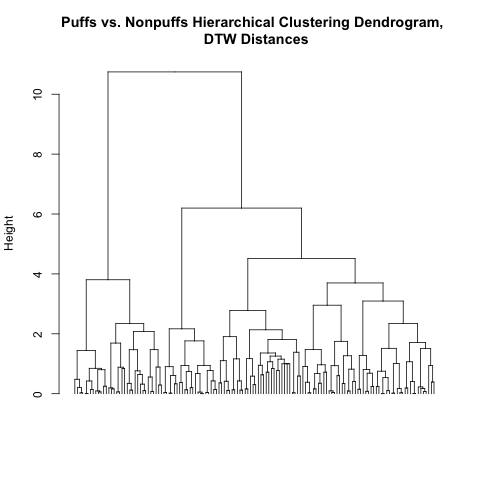

In [6]:
%%R

# plot a dendrogram of hierarchical clustering from the pairwise distance matrix
hc <- hclust(as.dist(t(dtw_merge_dists_combined)), "ward.D")
hcd <- as.dendrogram(hc)

plot(hcd, type = "rectangle", ylab = "Height", leaflab="none", 
     main = "Puffs vs. Nonpuffs Hierarchical Clustering Dendrogram, \n DTW Distances")

In [7]:
%%R
# make two cuts, see if we recover puff/nonpuff labels
cut <- cutree(hc, k=2)
true_labels <- scoredf_combined %>%
  select(particle, puff) %>%
  distinct() %>%
  pull(puff)

table(true_labels, cut)

           cut
true_labels   1   2
          0   0 100
          1  34   4


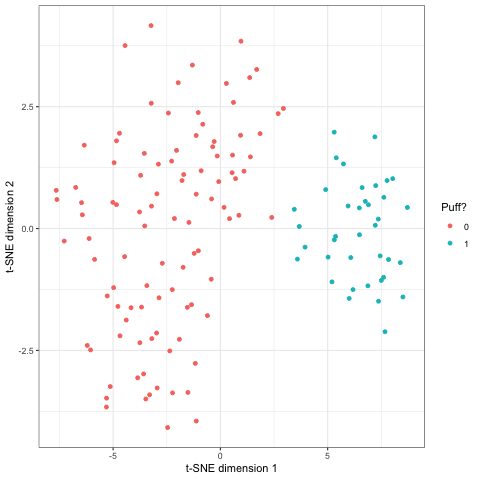

In [9]:
%%R
# make a t-SNE plot to visualize the pairwise distances, color by puff/nonpuff
suppressMessages(library(Rtsne))
suppressMessages(library(ggplot2))
tsne_out <- Rtsne(as.dist(t(dtw_merge_dists_combined)))

tsne_out$Y %>%
  data.frame() %>%
  ggplot2::ggplot(aes(x = X1, y = X2)) +
  geom_point(alpha=0.3, color="grey") +
  geom_point(data = (tsne_out$Y %>%
                       data.frame() %>%
                       mutate(puff = true_labels)), aes(color = as.factor(puff))) +
  labs(x = "t-SNE dimension 1", y = "t-SNE dimension 2", color = "Puff?") +
  theme_bw()

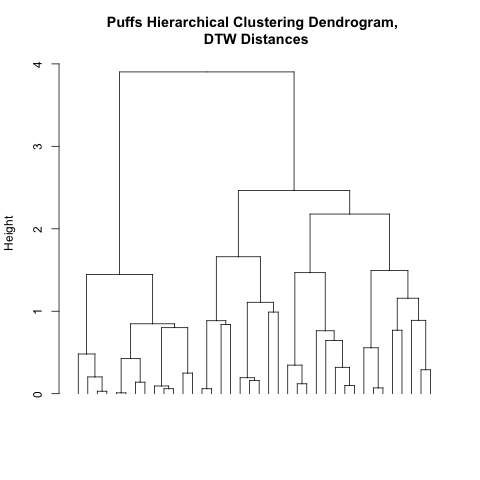

In [10]:
%%R
# now let's do some hierarchical clustering just on the puffs
dtw_merge_dists_puffs <- dtw_merge_dists_combined[1:sum(true_labels), 1:sum(true_labels)]
hc_puff <- hclust(as.dist(t(dtw_merge_dists_puffs)), "ward.D")
hcd_puff <- as.dendrogram(hc_puff)

plot(hcd_puff, type = "rectangle", ylab = "Height", leaflab="none", 
     main = "Puffs Hierarchical Clustering Dendrogram, \n DTW Distances")

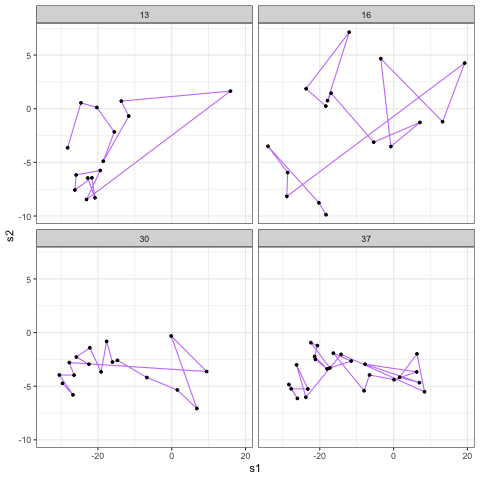

In [78]:
%%R
# cut tree to make a few clusters, look at the score paths for events in one of the clusters
cut_puff <- cutree(hc_puff, k = 4)

scoredf_combined %>%
  filter(cut_puff[particle] == 4) %>%
  group_by(particle) %>%
  nest() %>%
  sample_n(4) %>%
  unnest() %>%
  ungroup() %>%
  ggplot(aes(x = s1, y = s2)) +
  geom_path(color="#C680FC") +
  geom_point(size=1) +
  facet_wrap(~particle) +
  theme_bw() #+
  #scale_y_continuous(limits=c(-7,8))

In [25]:
%R -o scoredf_combined

In [38]:
print(scoredf_combined.colnames)

[1] "frame"    "particle" "s1"       "s2"       "s3"       "smooth1"  "smooth2" 
[8] "smooth3"  "puff"    



In [18]:
# Outputs a movie with a puff on the left and a PC trace on the right, with a red-dot tracking movement through PC space

def puff_pc_moviemaker(particle, puff_intensities, scoredf_opp):
    puff = puff_intensities[puff_intensities['particle'] == particle]
    puff_scores = scoredf_opp[scoredf_opp['particle'] == particle]

    moviewriter = manimation.FFMpegWriter(fps=10)

    vmin = np.min(puff['intensity'])
    vmax = np.max(puff['intensity'])

    num_frames = len(np.unique(puff['frame']))

    max_s1 = np.max(puff_scores['s1'])
    min_s1 = np.min(puff_scores['s1'])
    max_s2 = np.max(puff_scores['s2'])
    min_s2 = np.min(puff_scores['s2'])
    
    fig = plt.figure(figsize=(8,5))
    im_ax = plt.subplot2grid((2,2), (0,0), rowspan=2, fig=fig)
    with sns.axes_style('white'):
                s_ax = plt.subplot2grid((2,2), (0,1), rowspan=2,
                                         ylim = (min_s2 - np.abs(0.1*min_s2),
                                                 max_s2 + np.abs(0.1*max_s2)),
                                         xlim = (min_s1 - np.abs(0.1*min_s1),
                                                 max_s1 + np.abs(0.1*max_s1)),
                                         xlabel='PC Score 1',
                                         ylabel='PC Score 2',
                                         fig=fig)
                s_ax.plot(puff_scores['s1'], puff_scores['s2'],'k.-', zorder=1)

    with moviewriter.saving(fig,'partcile-'+str(particle)+'.mp4', dpi=100):
        for frame in np.unique(puff['frame']):
            relframe = frame - np.min(puff['frame'])

            cur_frame = puff[puff['frame']==frame].pivot_table(values=['intensity'],columns=['x'],index=['y']).values
            cur_s1 = puff_scores[puff_scores['frame'] <= frame]['s1'].values
            cur_s2 = puff_scores[puff_scores['frame'] <= frame]['s2'].values

            im_ax.imshow(cur_frame, cmap='gray', vmin=vmin, vmax=vmax)
            im_ax.axis('off')
            with sns.axes_style('white'):
                s_ax = plt.subplot2grid((2,2), (0,1), rowspan=2,
                                         ylim = (min_s2 - np.abs(0.1*min_s2),
                                                 max_s2 + np.abs(0.1*max_s2)),
                                         xlim = (min_s1 - np.abs(0.1*min_s1),
                                                 max_s1 + np.abs(0.1*max_s1)),
                                         xlabel='PC Score 1',
                                         ylabel='PC Score 2',
                                         fig=fig)
                s_ax.plot(puff_scores['s1'], puff_scores['s2'],'k.-', zorder=1)
                s_ax.scatter(cur_s1[-1], cur_s2[-1], s=40, c='r', zorder=2)
            sns.despine()
            plt.subplots_adjust(wspace=0.3)
            moviewriter.grab_frame()

In [39]:
%%R

puff_intensities_renumbered <- puff_intensities %>%
      mutate(particle = cumsum(c(1, diff(particle) != 0)))

In [41]:
%R -o puff_intensities_renumbered
np.save('puff_intensities_renumbered.npy',puff_intensities_renumbered)

In [43]:
puff_intensities_renumbered.columns

Index(['frame', 'x', 'y', 'particle', 'intensity'], dtype='object')